In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
recastData = pd.read_pickle('../scanResults.pcl')

### Get all model points

In [3]:
models = []
mCols = ['Coupling','Mode','$m_{med}$','$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
print('%i models loaded' %len(models))

43 models loaded


In [4]:
# Remove duplicated data from other datasets
modelData = recastData[recastData['Data-takingperiod'] == 2017]

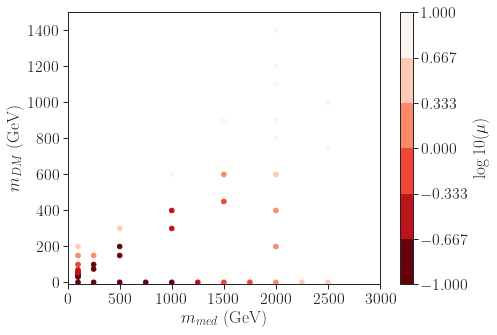

In [7]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=modelData['$m_{med}$'],y=modelData['$m_{DM}$'],vmin=-1.0,vmax=1.0,
            c=np.log10(modelData['$\mu^{UL}_{obs}$']),cmap=plt.cm.get_cmap('Reds_r', 6))
cbar = plt.colorbar(label=r'$\log10(\mu)$')
cbar.set_ticks([-1.0,-0.6666,-0.3333,0.0,0.33333,0.66666,1.0])
plt.xlabel(r'$m_{med}$ (GeV)')
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(-10,1500)
plt.xlim(0,3000)
plt.show()

In [14]:
from scipy.interpolate import interp2d,griddata

In [ ]:
pts = [itertools]

In [17]:
lmuPts = griddata(list(zip(modelData['$m_{med}$'],modelData['$m_{DM}$'])),modelData['$\mu^{UL}_{obs}$'],[[1500.,300.]])

In [18]:
lmuPts

array([0.65688419])